In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
tf.enable_eager_execution()

tfe = tf.contrib.eager

In [3]:
from math import pi

def f(x):
    return tf.square(tf.sin(x))

assert f(pi/2).numpy() == 1.0


# grad_f will return a list of derivatives of f
# with respect to its arguments. Since f() has a single argument,
# grad_f will return a list with a single element.
grad_f = tfe.gradients_function(f)
assert tf.abs(grad_f(pi/2)[0]).numpy() < 1e-7

TypeError: object of type 'EagerTensor' has no len()

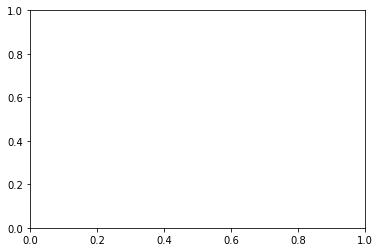

In [4]:
def f(x):
    return tf.square(tf.sin(x))

def grad(f):
    return lambda x: tfe.gradients_function(f)(x)[0]

x = tf.lin_space(-2*pi, 2*pi, 100) # 100 points between -2pi and +2pi
#print(x)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, f(x), label="f")
plt.plot(x, grad(f)(x), label="first derivative")
plt.plot(x, grad(grad(f))(x), label="second derivative")
plt.plot(x, grad(grad(grad(f)))(x), label="third derivative")
plt.legend()
plt.show()

In [5]:
def f(x, y):
    output = 1
    for i in range(y):
        output = tf.multiply(output, x)
    return output

def g(x, y):
  # Return the gradient of `f` with respect to it's first parameter
  return tfe.gradients_function(f)(x, y)[0]

assert f(3.0, 2).numpy() == 9.0   # f(x, 2) is essentially x * x
assert g(3.0, 2).numpy() == 6.0   # And its gradient will be 2 * x
assert f(4.0, 3).numpy() == 64.0  # f(x, 3) is essentially x * x * x
assert g(4.0, 3).numpy() == 48.0  # And its gradient will be 3 * x * x

TypeError: 'EagerTensor' object cannot be interpreted as an integer

In [8]:

x = tf.ones((2, 2))
  
# TODO(b/78880779): Remove the 'persistent=True' argument and use
# a single t.gradient() call when the bug is resolved.
with tf.GradientTape(persistent=True) as t:
  # TODO(ashankar): Explain with "watch" argument better?
    t.watch(x)
    y = tf.reduce_sum(x)
    z = tf.multiply(y, y)

# Use the same tape to compute the derivative of z with respect to the
# intermediate value y.
dz_dy = t.gradient(z, y)
assert dz_dy.numpy() == 8.0

# Derivative of z with respect to the original input tensor x
dz_dx = t.gradient(z, x)
for i in [0, 1]:
    for j in [0, 1]:
        assert dz_dx[i][j].numpy() == 8.0

In [9]:
# TODO(ashankar): Should we use the persistent tape here instead? Follow up on Tom and Alex's discussion

x = tf.constant(1.0)  # Convert the Python 1.0 to a Tensor object

with tf.GradientTape() as t:
    with tf.GradientTape() as t2:
        t2.watch(x)
        y = x * x * x
    # Compute the gradient inside the 't' context manager
    # which means the gradient computation is differentiable as well.
    dy_dx = t2.gradient(y, x)
d2y_dx2 = t.gradient(dy_dx, x)

assert dy_dx.numpy() == 3.0
assert d2y_dx2.numpy() == 6.0